# Sky Matching 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

When a user decided to mosaic several images it can be difficult to decide how to relate the background of one image to the others. AstroDrizzle has the ability to compute and then either subtract or equalize the background in input images in order to match the sky between those images. The function allows users to select the algorithm for the sky subtraction using the `skymethod` parameter. 

There are four methods available in sky matching: 'localmin', 'match', 'globalmin', 'globalmin+match'.

By applying `drizzlepac.sky.sky()`, or by applying the `skymethod` parameter in the call to `drizzlepac.astrodrizzle.AstroDrizzle()`, AstroDrizzle will update the keyword `MDRIZSKY` in the headers of the input files. 

The **recommended** use for images with sparse fields that have few astronomical sources is `skymethod = localmin` and for images with complicated backgrounds, such as nebulae and large host galaxies, `skymethod = match` is recommended.

For more information on the specifics of this function please refer to the documentation [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky).

Below, each of the four methods will be demonstrated using a single example dataset, and differences between the methods will be highlighted. 

In [1]:
# All imports needed through out this notebook are included at the beginning. 
import glob
import os
import shutil
from shutil import copyfile

from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

import drizzlepac
from drizzlepac import tweakreg
from drizzlepac import tweakback
from stwcs import updatewcs 

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Retrieve Observations using Astroquery

WFC3/IR observations of the Horsehead Nebula obtained in HST proposal 12812 (PI: Levay) will be used for this demonstration. The images have been processed by the HST WFC3 pipeline (calwf3), which includes bias subtraction, dark current correction, cosmic-ray rejection, and flatfielding.

The alignment specifics for this example are based on the example found [here](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt). We will provide explanation about the process as we go. 

The code used to retrieve the data from astroquery is below.

In [2]:
# Retrieve the observation information.
obs_table = Observations.query_criteria(proposal_id='12812', filters=["F160W"], project='HST')
obs_table.show_in_notebook()

# Figure out the downloadable products:
dataProductsByObservation = Observations.get_product_list(obs_table)
dataProductsByObservation.show_in_notebook()

# Download the flc.fits files: 
obsids = obs_table['obsid']

# Download the data - uncomment to download: 
Observations.download_products(obsids, mrp_only=False, productSubGroupDescription=['FLT', 'DRZ'])

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str87,str8,object,object
./mastDownload/HLA/hst_12812_58_wfc3_ir_f160w/hst_12812_58_wfc3_ir_f160w_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_58_wfc3_ir_f160w_01/hst_12812_58_wfc3_ir_f160w_01_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_58_wfc3_ir_f160w_02/hst_12812_58_wfc3_ir_f160w_02_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58030/ibxl58030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58sqq/ibxl58sqq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58svq/ibxl58svq_flt.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_51_wfc3_ir_f160w/hst_12812_51_wfc3_ir_f160w_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_51_wfc3_ir_f160w_01/hst_12812_51_wfc3_ir_f160w_01_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_51_wfc3_ir_f160w_02/hst_12812_51_wfc3_ir_f160w_02_drz.fits,COMPLETE,None,None


### Move files to the local directory 

In [3]:
flt_files = glob.glob('mastDownload/*/*/*flt.fits')

for file in flt_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_flt.fits"
    copyfile(file, dst)

drz_files = glob.glob('mastDownload/*/*/*drz.fits')

for file in drz_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_drz.fits"
    copyfile(file, dst)

### Inspect the image headers

In [4]:
collect_flt = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
flt_table = collect_flt.summary
flt_table['exptime'].format = '7.1f'
flt_table['postarg1'].format = '7.2f'
flt_table['postarg2'].format = '7.2f'
flt_table

file,asn_id,detector,filter,exptime,postarg1,postarg2
str18,str9,str2,str5,float64,float64,float64
ibxl50clq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-113.11
ibxl50cqq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-105.91
ibxl51eoq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-113.11
ibxl51etq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-105.91
ibxl52k0q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-113.11
ibxl52k5q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-105.91
ibxl53kxq_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,-3.60
ibxl53l9q_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,3.60
ibxl54bgq_flt.fits,IBXL54030,IR,F160W,702.9,0.00,-3.60


In [5]:
collect_drz = ImageFileCollection('./', glob_include="*drz.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime"])
    
drz_table = collect_drz.summary
drz_table['exptime'].format = '7.1f'
drz_table

file,asn_id,detector,filter,exptime
str41,str9,str2,str5,float64
hst_12812_50_wfc3_ir_f160w_run_1_drz.fits,IBXL50030,IR,F160W,1405.9
hst_12812_51_wfc3_ir_f160w_run_1_drz.fits,IBXL51030,IR,F160W,1405.9
hst_12812_52_wfc3_ir_f160w_run_1_drz.fits,IBXL52030,IR,F160W,1405.9
hst_12812_53_wfc3_ir_f160w_run_1_drz.fits,IBXL53030,IR,F160W,1405.9
hst_12812_54_wfc3_ir_f160w_run_1_drz.fits,IBXL54030,IR,F160W,1405.9
hst_12812_55_wfc3_ir_f160w_run_1_drz.fits,IBXL55030,IR,F160W,1405.9
hst_12812_56_wfc3_ir_f160w_run_1_drz.fits,IBXL56030,IR,F160W,1405.9
hst_12812_57_wfc3_ir_f160w_run_1_drz.fits,IBXL57030,IR,F160W,1405.9
hst_12812_58_wfc3_ir_f160w_run_1_drz.fits,IBXL58030,IR,F160W,1405.9


## 2. Align the visit-level drizzled data

Exposures obtained within a single HST visit tend to be aligned very well since they use the same guide stars. Thus, we will use TweakReg to align the DRZ files and then use TweakBack to propagate those solutions back to the FLT image headers prior to combining with AstroDrizzle. Making use of the parameter `expand_refcat`, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. For this dataset, we obtain the best results when we tell TweakReg to align the DRZ files in a specific order, and this is achieved by giving a list of files as input. More details on alignment of HST mosaics can be found in the notebook 'mosaics.ipynb' in this repository.
    
    drz.list
    ibxl54030_drz.fits	<-- Note that tile 54 is the reference and is listed first
    ibxl51030_drz.fits  
    ibxl53030_drz.fits
    ibxl55030_drz.fits
    ibxl57030_drz.fits
    ibxl50030_drz.fits
    ibxl52030_drz.fits
    ibxl56030_drz.fits
    ibxl58030_drz.fits
      ____ ____ ____
     |    |    |    |    <-- The 4 tiles with the most overlap are aligned first
     |    | 55 |    |
     |____|____|____|
     |    |    |    |
     | 57 | 54 | 51 |
     |____|____|____|
     |    |    |    |
     |    | 53 |    |
     |____|____|____|
   
      ____ ____ ____
     |    |    |    |    <-- Then the corner tiles are added 
     | 58 |    | 52 |
     |____|____|____|
     |    |    |    |
     |    |    |    |
     |____|____|____|
     |    |    |    |
     | 56 |    | 50 |
     |____|____|____|

This allows TweakReg to start with the tiles with the most overlap first and then build upon that, expanding the reference catalog as each new tile is aligned. 

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 01:19:38.560 (18/12/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 01:19:38.560 (18/12/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.7.5 (default, Oct 25 2019, 10:52:18) 


3.7.5 (default, Oct 25 2019, 10:52:18) 


INFO:drizzlepac.util:numpy Version -> 1.17.4 


numpy Version -> 1.17.4 


INFO:drizzlepac.util:astropy Version -> 3.2.3 


astropy Version -> 3.2.3 


INFO:drizzlepac.util:stwcs Version -> 1.5.3 


stwcs Version -> 1.5.3 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:ibxl54030_drz.fits


ibxl54030_drz.fits


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibxl54030_drz.fits


    ibxl54030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl51030_drz.fits


    ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl53030_drz.fits


    ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl55030_drz.fits


    ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl57030_drz.fits


    ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl50030_drz.fits


    ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl52030_drz.fits


    ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl56030_drz.fits


    ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl58030_drz.fits


    ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	4.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	1


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	10


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl54030_drz.fits':


===  Source finding for image 'ibxl54030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 01:19:38.907 (18/12/2019)


  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 01:19:38.907 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.543311


  tdata=np.where(convdata > threshold, convdata, 0)



INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:39.0 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 38 objects.


     Found 38 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl54030_drz.fits': 38


===  FINAL number of objects in image 'ibxl54030_drz.fits': 38


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl51030_drz.fits':


===  Source finding for image 'ibxl51030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.138 (18/12/2019)


  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.138 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.553781


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:39.260 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 52 objects.


     Found 52 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl51030_drz.fits': 52


===  FINAL number of objects in image 'ibxl51030_drz.fits': 52


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl53030_drz.fits':


===  Source finding for image 'ibxl53030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.350 (18/12/2019)


  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.350 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.527635


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:39.481 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 36 objects.


     Found 36 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl53030_drz.fits': 36


===  FINAL number of objects in image 'ibxl53030_drz.fits': 36


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl55030_drz.fits':


===  Source finding for image 'ibxl55030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.568 (18/12/2019)


  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.568 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.259246


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:39.689 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 55 objects.


     Found 55 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl55030_drz.fits': 55


===  FINAL number of objects in image 'ibxl55030_drz.fits': 55


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl57030_drz.fits':


===  Source finding for image 'ibxl57030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.77 (18/12/2019)


  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.77 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.505249


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:39.900 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 65 objects.


     Found 65 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl57030_drz.fits': 65


===  FINAL number of objects in image 'ibxl57030_drz.fits': 65


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl50030_drz.fits':


===  Source finding for image 'ibxl50030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.999 (18/12/2019)


  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 01:19:39.999 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.553639


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:40.12 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 57 objects.


     Found 57 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl50030_drz.fits': 57


===  FINAL number of objects in image 'ibxl50030_drz.fits': 57


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl52030_drz.fits':


===  Source finding for image 'ibxl52030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 01:19:40.278 (18/12/2019)


  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 01:19:40.278 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.240202


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:40.395 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 59 objects.


     Found 59 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl52030_drz.fits': 59


===  FINAL number of objects in image 'ibxl52030_drz.fits': 59


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl56030_drz.fits':


===  Source finding for image 'ibxl56030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 01:19:40.493 (18/12/2019)


  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 01:19:40.493 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.619044


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:40.612 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 47 objects.


     Found 47 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl56030_drz.fits': 47


===  FINAL number of objects in image 'ibxl56030_drz.fits': 47


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl58030_drz.fits':


===  Source finding for image 'ibxl58030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 01:19:40.705 (18/12/2019)


  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 01:19:40.705 (18/12/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.247739


INFO:drizzlepac.catalogs:###Source finding finished at: 01:19:40.824 (18/12/2019)


INFO:drizzlepac.catalogs:     Found 65 objects.


     Found 65 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl58030_drz.fits': 65


===  FINAL number of objects in image 'ibxl58030_drz.fits': 65


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibxl54030_drz.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibxl54030_drz.fits'


derived from 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	3.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.5


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift4_drc.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl51030_drz.fits


Performing fit for: ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.3918, -0.3918 with significance of 4 and 4 matches


Found initial X and Y shifts of -0.3918, -0.3918 with significance of 4 and 4 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl51030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl51030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -4.392, -0.3918 based on a single non-zero bin and 3 matches


Found initial X and Y shifts of -4.392, -0.3918 based on a single non-zero bin and 3 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl55030_drz.fits


Performing fit for: ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.3918, -0.3918 based on a single non-zero bin and 4 matches


Found initial X and Y shifts of -0.3918, -0.3918 based on a single non-zero bin and 4 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl55030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl55030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl57030_drz.fits


Performing fit for: ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


ERROR:stsci.tools.logutil.exc:An unhandled exception ocurred:
Traceback (most recent call last):
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/util.py", line 225, in wrapper
    result = func(*args, **kwargs)
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/tweakreg.py", line 551, in run
    image.match(refimage, quiet_identity=False, **objmatch_par)
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/imgclasses.py", line 521, in match
    searchrad=radius
  File "/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/drizzlepac/imgclasses.py", line 1670, in _estimate_2dhist_shift
    .format(xp, yp, sig, flux))
UnboundLocalError: local variable 'sig' referenced before assignment


UnboundLocalError: local variable 'sig' referenced before assignment

UnboundLocalError: local variable 'sig' referenced before assignment

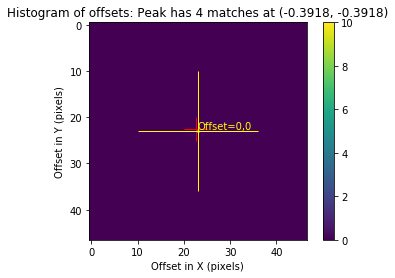

In [6]:
tweakreg.TweakReg('@drz.list', 
                  imagefindcfg={'threshold': 10, 'conv_width': 4.5, 'peakmin': 1}, 
                  minobj=5, 
                  shiftfile=True, 
                  expand_refcat=True, 
                  enforce_user_order=True, 
                  outshifts='shift4_drc.txt',
                  searchrad=3.0,
                  ylimit=0.5, 
                  updatehdr=True, 
                  interactive=False)

Tweakback is then run on the aligned DRZ files to propogate the updated WCS information back to the FLT files.

In [ ]:
drz_files = glob.glob('i*_drz.fits')

for f in drz_files:
    tweakback.tweakback(f, verbose=True)

## 3. Compare  `skymethod` options in AstroDrizzle

### `skymethod = 'localmin'`

When using AstroDrizzle to compute the sky in each frame, 'localmin' will compute a common sky for all members of an exposure, as described [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky). This algorithm is recommended when images are dominated by blank sky instead of extended, diffuse sources.

For a typical use, it will compute sky values for each chip/image extension (marked for sky subtraction in the input parameter) in an input image, and it will subtract the previously found minimum sky value from all chips in that image. This process is repeated for each input image.

In the command below, the aligned FLT frames are sky subtracted and drizzled together. Because the WFC3/IR data products are already cleaned of cosmic rays during calwf3 processing, cosmic-ray rejection is turned off in AstroDrizzle by setting the parameters `driz_separate`, `median`, `blot`, and `driz_cr` to 'False'.

In [ ]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_localmin',
                                     preserve=False, 
                                     skymethod='localmin', 
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

### `skymethod = 'match'`

When `skymethod` is set to ‘match’, differences in sky values between images in common sky regions will be computed. Thus, sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to and reported as 0. This setting “equalizes” sky values between the images in large mosaics. 

This is the **recommended** setting for images containing diffuse sources (e.g., galaxies, nebulae) covering significant parts of the image.

In [ ]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_match',
                                     preserve=False, 
                                     skymethod='match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

### `skymethod = 'globalmin+match'`

When `skymethod` is set to ‘globalmin+match', AstroDrizzle will first find a minimum “global” sky value in all input images and then use the ‘match’ method to equalize sky values between images.

In [ ]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin_match',
                                     preserve=False, 
                                     skymethod='globalmin+match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

### `skymethod = 'globalmin'`

When `skymethod` is set to ‘globalmin’, a common sky value will be computed for all exposures. AstroDrizzle will compute sky values for each chip/image extension, find the minimum sky value from all the exposures, and then subtract that minimum sky value from all chips in all images. 

This method may be useful when input images already have matched background values.

In [ ]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin',     
                                     preserve=False,
                                     skymethod='globalmin',     
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

## 4. Compare the MDRIZSKY values for each method

Below we provide a gif comparing the upper portion of the final drizzled image. We cycle through three of the versions that use different `skymethod` algorithms:  

![SegmentLocal](labeled_local_globalmatch_match.gif)

Below is the code used to compare results from the various skymatching methods. It's best practice to use more compact for loops when possible in situations like this, but we wanted to write out each file to ensure we are gathering the proper `MDRIZSKY` values for each `skymethod` run. We also display a table (Pandas DataFrame) of the different sky matching `MDRIZSKY` values for comparison.

In [ ]:
# This is a quick method of opening our different results and gathering the `MDRIZSKY` values: 
im = fits.open("f160w_globalmin_drz_sci.fits")
rootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
mdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_globalmin_match_drz_sci.fits")
globalmatchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
globalmatchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_match_drz_sci.fits")
matchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
matchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_localmin_drz_sci.fits")
localrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
localmdrizsky = im[1].data['MDRIZSKY']
im.close()

mdrizsky_val = pd.DataFrame(
    {'Rootname': rootname,
     'globalmin': mdrizsky,
     'globalmin_match': globalmatchmdrizsky,
     'match': matchmdrizsky,
     'local': localmdrizsky})

mdrizsky_val

These computed sky values can be visualized in the plot below. To reiterate, the MDRIZSKY keyword reports the value subtracted from each image, and not the sky level itself. Thus the values for `skymethod='match'` are close to zero. We also note that varying background levels across the individual tiles result in inaccurate sky background determination when `skymethod='match'` and thus a mismatched sky in the final mosaic.

In [ ]:
index = mdrizsky_val.index.tolist()
globalmin = list(mdrizsky_val['globalmin'])
globalmin_match = list(mdrizsky_val['globalmin_match'])
match = list(mdrizsky_val['match'])
local = list(mdrizsky_val['local'])

#Plotting code: 
fig = plt.figure(figsize=[10,10])
plt.scatter(index, globalmin_match, color='magenta', label='Globalmin + Match')
plt.scatter(index, match, color='navy', label='Match')
plt.scatter(index, local, color='olive', label='Local')
plt.scatter(index, globalmin, color = 'orange', label='Globalmin')
plt.xlabel('Individual Images')
plt.ylabel('MDRIZSKY Value')
plt.legend(loc="center left")
plt.xticks(index)
plt.tight_layout()

## 5. Display the full 'matched' mosaic 

In [ ]:
sci = fits.getdata('f160w_match_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=-0.4, vmax=3, cmap='Greys_r', origin='lower')

# About this Notebook

    Author: C. Martlin, STScI WFC3 Team  
    Updated: December, 14 2018